# Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import numpy as np
from tqdm import tqdm
import dask.dataframe as dd

from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers import TimeDistributed
from keras.layers.recurrent import LSTM
from keras.layers import Dense, Conv1D, MaxPool2D, Flatten, Dropout, CuDNNGRU, CuDNNLSTM, Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam, SGD, Nadam
from time import time
from livelossplot import PlotLossesKeras
from keras.layers.advanced_activations import LeakyReLU, PReLU
import tensorflow as tf
from keras.utils.training_utils import multi_gpu_model
from tensorflow.python.client import device_lib
from sklearn.preprocessing import StandardScaler

from keijzer import *

%matplotlib inline
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"} # Make sure the axis background of plots is white, this is usefull for the black theme in JupyterLab
sns.set()

Using TensorFlow backend.


In [2]:
# Setup multi GPU usage
num_gpu = setup_multi_gpus()

Amount of GPUs available: 1


# Load data

In [3]:
%pwd

'D:\\Brian\\JupyterLab\\Multivariate-time-series-models-in-Keras\\notebooks'

In [4]:
path = _
path = path[:-10] # removes '\\notebooks' from the path string

df = pd.read_csv(path+"\\data\\house_data_processed.csv", delimiter='\t', parse_dates=['datetime'])
df = df.set_index(['datetime']) 

magnitude = 1 # Take this from the 1. EDA & Feauture engineering notebook. It's the factor where gasPower has been scaled with to the power 10.

In [5]:
df.head()

,ePower,DD,FF,N,Q,RG,T,U,gasPower,gasPower_std,hour,dayofweek,season
datetime,,,,,,,,,,,,,
2017-02-28 12:00:00,308.321701,213.524994,9.067500,8.000000,112.500000,0.0,5.183333,82.666664,6.115723,0.085626,12,1,1
2017-02-28 13:00:00,263.656273,212.316666,8.684999,8.000000,144.399994,0.0,5.300000,82.000000,5.238647,0.318250,13,1,1
2017-02-28 14:00:00,181.913345,224.399994,8.296667,7.000000,151.666672,0.0,5.283333,79.666664,2.451172,0.041087,14,1,1
2017-02-28 15:00:00,378.613129,226.983337,6.918334,6.833333,246.666672,0.0,5.516667,80.833336,3.065186,0.214238,15,1,1
2017-02-28 16:00:00,332.392082,239.449997,6.583333,6.833333,212.166672,0.0,5.433333,79.166664,8.120117,0.014156,16,1,1


# Preprocessing
Prepare the data for the used model.

In [6]:
data = df.copy()

## Datetime info to categorical
Certain functions are able to use the Pandas categorical datatype, e.g. they don't require the feautures to be one-hot encoded.  

In [7]:
columns_to_category = ['hour', 'dayofweek', 'season']
#data[columns_to_category] = data[columns_to_category].astype('category') # change datetypes to category

# One hot encoding // dummy variables
One hot encode the categorical feautures.

In [8]:
data = pd.get_dummies(data, columns=columns_to_category) # One hot encoding the categories
data.head()

,ePower,DD,FF,N,Q,RG,T,U,gasPower,gasPower_std,...,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6,season_1,season_2,season_3,season_4
datetime,,,,,,,,,,,,,,,,,,,,,
2017-02-28 12:00:00,308.321701,213.524994,9.067500,8.000000,112.500000,0.0,5.183333,82.666664,6.115723,0.085626,...,1,0,0,0,0,0,1,0,0,0
2017-02-28 13:00:00,263.656273,212.316666,8.684999,8.000000,144.399994,0.0,5.300000,82.000000,5.238647,0.318250,...,1,0,0,0,0,0,1,0,0,0
2017-02-28 14:00:00,181.913345,224.399994,8.296667,7.000000,151.666672,0.0,5.283333,79.666664,2.451172,0.041087,...,1,0,0,0,0,0,1,0,0,0
2017-02-28 15:00:00,378.613129,226.983337,6.918334,6.833333,246.666672,0.0,5.516667,80.833336,3.065186,0.214238,...,1,0,0,0,0,0,1,0,0,0
2017-02-28 16:00:00,332.392082,239.449997,6.583333,6.833333,212.166672,0.0,5.433333,79.166664,8.120117,0.014156,...,1,0,0,0,0,0,1,0,0,0


# Preprocessing, data to CNN format
Setting the `look_back`, `test_size` and some other parameters.  
Remember how the `df_to_lstm_rnn_format()` function splits the data into train & test and also has the ability to scale the X data per column.

In [9]:
look_back = 5 # D -> 5, H -> 5*24
num_features = data.shape[1] - 1
output_dim = 1
train_size = 0.7

X_train, y_train, X_test, y_test = df_to_cnn_rnn_format(df=data, train_size=train_size, look_back=look_back, target_column='gasPower', scale_X=True)

Taking a look of the train shape.  
There are (number of samples, rows, columns)

In [10]:
X_train.shape

(4441, 5, 44)

# Visualization of the train & test set target values

# The complete dataset

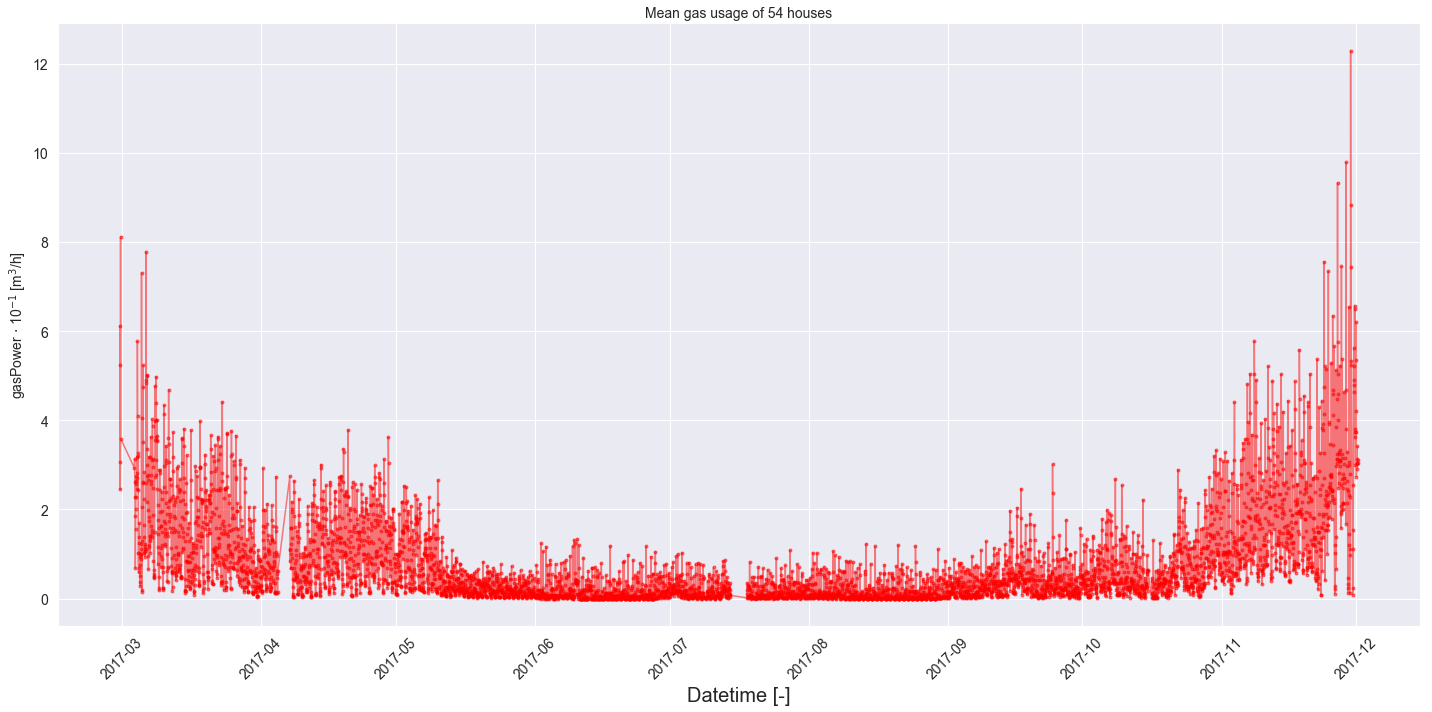

In [11]:
plt.figure(figsize=(20,10))

plt.plot(data.index, data['gasPower'], '.-', color='red', label='Original data', alpha=0.5)
plt.xlabel('Datetime [-]', fontsize=20)
plt.ylabel(r'gasPower $\cdot$ 10$^{-%s}$ [m$^3$/h]' % (magnitude), fontsize=14)

plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)

plt.title('Mean gas usage of 54 houses', fontsize=14)

plt.tight_layout()

#plt.savefig('figures/available data.png', dpi=1200)

# The train & test set

`TODO: Fix te look_back time difference.`  
For example, when loockback is 120 days, X_train length will be 4446 and y_train 4326...  
y_train is 120 shorter than X_train because the first 120 y values cannot be predicted due there not being 120 historical X values...  
So in the plots below there might be a 120 hour datetime difference with the actual datetime.  

In [12]:
"""
Get the X_train and X_test datetime values
"""
split_index = int(data.shape[0]*train_size)

X_train_values = data[:split_index] # get the datetime values of X_train
X_test_values = data[split_index:] # get the datetime values of X_train

In [13]:
X_train_values.shape, y_train.shape

((4446, 45), (4441,))

In [14]:
X_test_values.shape, y_test.shape

((1906, 45), (1901,))

Temporary fix for the datetime length difference.

In [15]:
datetime_difference = len(X_train_values) - len(y_train)
X_train_values = X_train_values[datetime_difference:] # Correct for datetime difference, this is a dirty way of doing it
X_train_values.shape, y_train.shape

datetime_difference = len(X_test_values) - len(y_test)
X_test_values = X_test_values[datetime_difference:] # Correct for datetime difference, this is a dirty way of doing it
X_test_values.shape, y_test.shape

((1901, 45), (1901,))

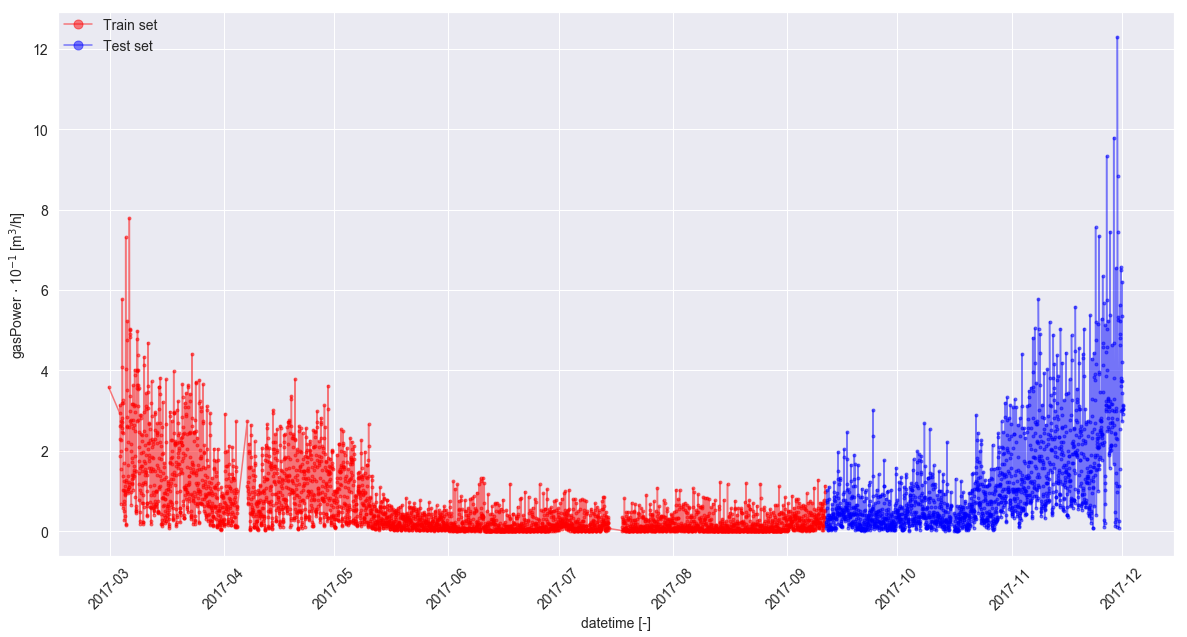

In [16]:
"""
Create the plot
"""
plt.figure(figsize=(20,10))

plt.plot(X_train_values.index, y_train, '.-', color='red', label='Train set', alpha=0.5)
plt.plot(X_test_values.index, y_test, '.-', color='blue', label='Test set', alpha=0.5)

plt.ylabel(r'gasPower $\cdot$ 10$^{-%s}$ [m$^3$/h]' % magnitude, fontsize=14)
plt.xlabel('datetime [-]', fontsize=14) #TODO: set x values as actual dates

plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)

plt.legend(loc='upper left', borderaxespad=0, frameon=False, fontsize=14, markerscale=3)

# Adding the channel dimension to the X data
The channnel dimension is required for CNNs.  
Channel would be 3 for RGB, 1 for grey-scaled images.  

In [17]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
X_train.shape

(4441, 5, 44, 1)

# CNN Model

In [18]:
seed = 42

"""
For info on batch normalization: https://github.com/ducha-aiki/caffenet-benchmark/blob/master/batchnorm.md
CuDNN.... Use GPU implementations of .... model, this speeds up the training.
"""

from keras.layers import InputLayer, ConvLSTM2D, Reshape, GRU, CuDNNLSTM, CuDNNGRU
from keras.layers.normalization import BatchNormalization

"""
For info on batch normalization: https://github.com/ducha-aiki/caffenet-benchmark/blob/master/batchnorm.md
CuDNN.... Use GPU implementations of .... model, this speeds up the training.
"""

from keras.layers import InputLayer, ConvLSTM2D, Reshape, GRU, CuDNNLSTM, CuDNNGRU
from keras.layers.normalization import BatchNormalization

input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])

dropout = 0.2


model = Sequential()

# Input shape: (samples, time, channels, rows, cols) see: https://keras.io/layers/recurrent/#convlstm2d
model.add(Conv2D(
        filters=16,
        kernel_size=(5, 9),
        input_shape=input_shape,
        padding='same', kernel_initializer='TruncatedNormal'))
model.add(LeakyReLU())
model.add(BatchNormalization())
model.add(Dropout(dropout))


"""
DNN
"""
model.add(Flatten())
#model.add(Flatten())
#print('Flatten Output: ' , model.output_shape)

model.add(Dense(128))
model.add(LeakyReLU())
model.add(Dropout(dropout, seed=seed))

model.add(Dense(64))
model.add(LeakyReLU())
model.add(Dropout(dropout, seed=seed))

model.add(Dense(units=output_dim))


#print(model.summary())

#multi_model = multi_gpu_model(model, gpus=num_gpu)

# Compile the model
Also set some hyperparameters like the learning rate (lr), amount of epochs and the batch size (bs).

In [24]:
"""
Look back , 5
nodes, 35

More only makes the model more complex and harder/slower to train
"""

epochs = 1000
bs = 2**13
lr = 1e-3 #6e-4
print(bs)

8192


In [25]:
# 0.05 0.9 0 True
sgd = SGD(lr=0.5, momentum=0.9, decay=0, nesterov=True) # sgd in general yields better results, but needs a lot of tweeking and is slower
adam = Adam(lr=lr)
nadam = Nadam(lr=lr)

# compile & fit
model.compile(optimizer=adam, loss = ['mse'], metrics=[mape, smape])

# Fit the model

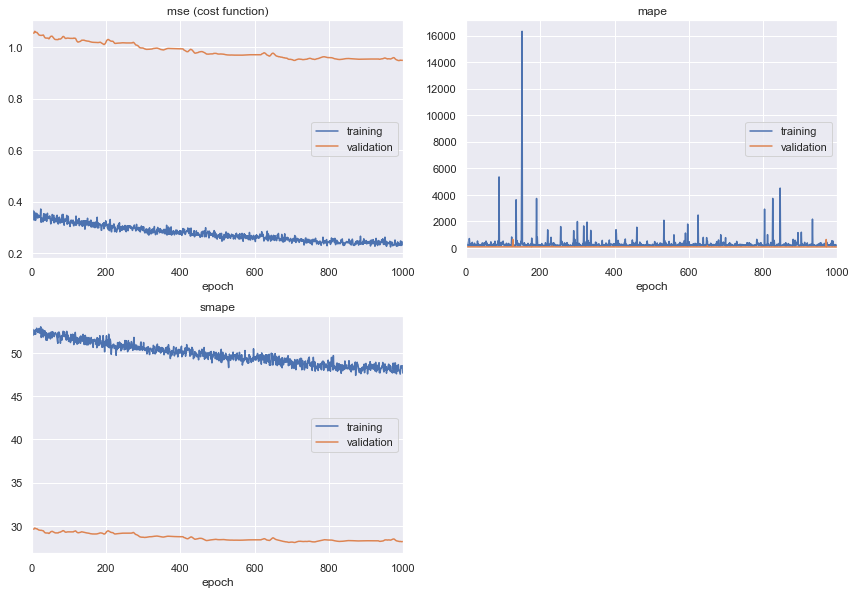

mse (cost function):
training   (min:    0.223, max:    0.376, cur:    0.233)
validation (min:    0.948, max:    1.062, cur:    0.949)

mape:
training   (min:  130.548, max: 16323.227, cur:  213.688)
validation (min:   72.624, max:  646.376, cur:   74.200)

smape:
training   (min:   47.395, max:   53.010, cur:   47.969)
validation (min:   28.071, max:   29.750, cur:   28.184)

Epoch 01000: val_mape did not improve from 72.62392
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 5, 44, 16)         736       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 5, 44, 16)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 5, 44, 16)         64        
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 4

In [39]:
early_stopping_monitor = EarlyStopping(patience=5000)

# This is used to save the best model, currently monitoring val_mape
# checkpoint
filepath="models\\CNN.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_mape', verbose=1, save_best_only=True, mode='min')

epoch_size = 1
schedule = SGDRScheduler(min_lr=1e-5, #1e-5
                                     max_lr=1e-2, # 1e-2
                                     steps_per_epoch=np.ceil(epoch_size/bs),
                                     lr_decay=0.9,
                                     cycle_length=5, # 5
                                     mult_factor=1.5)

model.fit(X_train, y_train, epochs=epochs, batch_size=bs, validation_data=(X_test, y_test),
         verbose=1, callbacks=[PlotLossesKeras(), early_stopping_monitor, checkpoint, schedule])

print(model.summary())

# Load the saved model

In [30]:
%time
from keras.models import load_model

# Load the architecture
model = load_model('models\\CNN.best.hdf5', custom_objects={'smape': smape, 
                                                    'mape': mape}) # Gave an error when loading without 'custom_objects'.. fixed by https://github.com/keras-team/keras/issues/3911

# Compile with the same settings as it has been saved with earlier
model.compile(loss='mse', metrics=[mape, smape], optimizer=adam)

print('FINISHED')

Wall time: 0 ns
FINISHED


# Cross validate on the test set

In [31]:
y_pred = model.predict(X_test)
y_true = y_test.reshape(y_test.shape[0], 1)

split_index = int(data.shape[0]*train_size)
x = data[split_index:]

datetime_difference = len(x) - len(y_true)
x = x[datetime_difference:] # Correct for datetime difference, this is a dirty way of doing it

1901/1901 [==============================] - 0s 149us/step
FINISHED


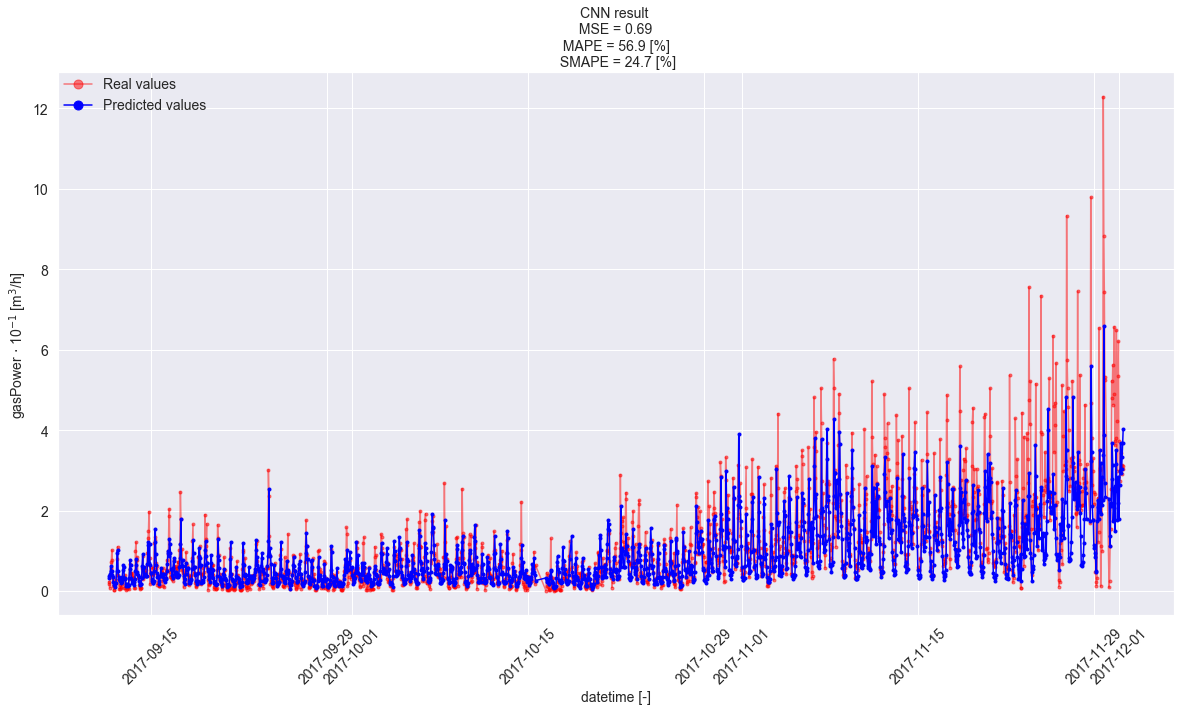

In [32]:
plt.figure(figsize=(20,10))
plt.plot(x.index, y_true, '.-', color='red', label='Real values', alpha=0.5)
plt.plot(x.index, y_pred, '.-', color='blue', label='Predicted values', alpha=1)

plt.ylabel(r'gasPower $\cdot$ 10$^{-%s}$ [m$^3$/h]' % magnitude, fontsize=14)
plt.xlabel('datetime [-]', fontsize=14) #TODO: set x values as actual dates

plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)

plt.legend(loc='upper left', borderaxespad=0, frameon=False, fontsize=14, markerscale=3)

mse_result, mape_result, smape_result = model.evaluate(X_test, y_test)

plt.title('CNN result \n MSE = %.2f \n MAPE = %.1f [%%] \n SMAPE = %.1f [%%]' % (mse_result, mape_result, smape_result), fontsize = 14)

#plt.savefig('figures/Feedforward result hourly without dummy variables.png', dpi=1200)
print('FINISHED')

# Downsample these results to a day

In [33]:
# Make it a df to be able to downsample
datetime = x.index
print(datetime.shape)

y_pred = y_pred.reshape(y_pred.shape[0])
y_true = y_true.reshape(y_true.shape[0])

results = pd.DataFrame(y_true, y_pred) # For some reason y_true becomes the index
result = results.reset_index() # Ugly way to fix above problem
result.columns = ['y_pred', 'y_true']

result['datetime'] = datetime
result = result.set_index(['datetime'])

# Save the model results for later usage
result.to_csv('models\\CNN_predictions.csv')

result = result.resample('D').sum() # Resample data

result = result.dropna()

(1901,)


In [34]:
# Calculate evaluation metrics over the result

ytrue = result['y_true']
ypred = result['y_pred']
n = len(result)


# Recalculated the metrics for the downsampled results
mse_result = (1/n)*np.sum((ypred - ytrue)**2)
mape_result = (100/n) * np.sum(np.abs((ytrue - ypred) / ypred))
smape_result = (100/n) * np.sum( np.abs((ytrue - ypred)) / (np.abs(ytrue) + np.abs(ypred)) )

Text(0.5, 1.0, 'CNN result \n MSE = 96.38 \n MAPE = 22.9 [%] \n SMAPE = 10.0 [%]')

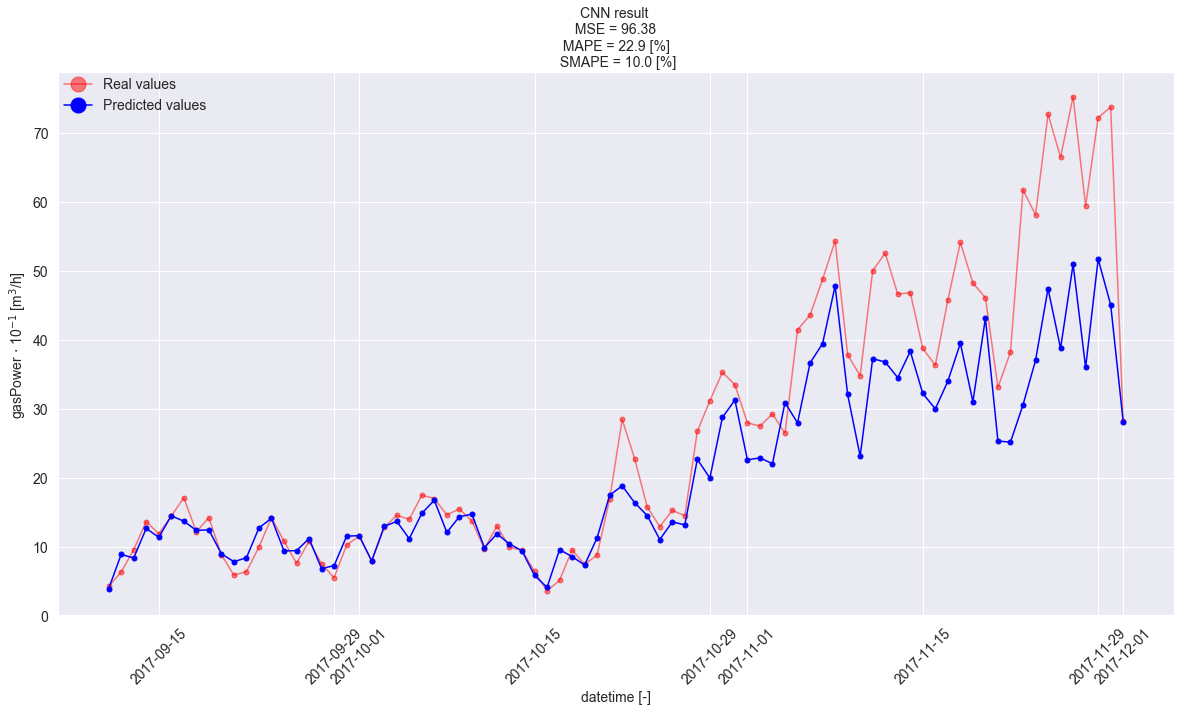

In [35]:
# Create plot
plt.figure(figsize=(20,10))
plt.plot(result.index, result['y_true'], '.-', color='red', label='Real values', alpha=0.5, ms=10) # ms is markersize
plt.plot(result.index, result['y_pred'], '.-', color='blue', label='Predicted values', ms=10)

plt.ylabel(r'gasPower $\cdot$ 10$^{-%s}$ [m$^3$/h]' % magnitude, fontsize=14)
plt.xlabel('datetime [-]', fontsize=14) #TODO: set x values as actual dates

plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)

plt.legend(loc='upper left', borderaxespad=0, frameon=False, fontsize=14, markerscale=3)

plt.title('CNN result \n MSE = %.2f \n MAPE = %.1f [%%] \n SMAPE = %.1f [%%]' % (mse_result, mape_result, smape_result), fontsize = 14)

#plt.savefig('figures/LSTM result hourly resampled to daily by sum.png', dpi=300)